In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# I. Introduction et motivations

### Objectif Global :
Le double objectif de ce projet est : 
- La prise en main/découverte de different outil de Machine Learning sur Python.
- L'étude des performances de prédiction de nos outils sur nos données.

Pour ce faire nous avons choisit d'appliquer notre travail sur un problème de sociale majeur : La discrimination sur le marché de l'immobilier. Le recherche d'une base de données sur sujet a été compliqué. Ainsi, nous nous sommes concentré sur la question de l'ocroit ou non d'un pret immobilier, grâce à une base de données receuilli dans les années 90 par la réserve féderal de Boston. L'intérêt pour nous et de savoir si l'éthnie d'un demandeurs de prêt immobilier peut impacter l'octroi de son crédit.
Beaucoup d'etude ont été réalisé sur ce sujet dans les années 70 à 90 aux États-Unis. Il peut être intéressant de comparer nos résultats à ces données.


### Découverte des variables de la base de données :


In [24]:
data = pd.read_csv('Loan_data.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 20 columns):
approve       1989 non-null int64
loanamt       1989 non-null int64
term          1989 non-null float64
caution       1989 non-null int64
atotinc       1989 non-null int64
cototinc      1989 non-null float64
hrat          1989 non-null float64
obrat         1989 non-null float64
sex           1974 non-null object
university    1989 non-null int64
race          1989 non-null object
married       1986 non-null float64
dep           1986 non-null float64
exper         1989 non-null int64
self          1989 non-null int64
score         1980 non-null float64
delinq        1989 non-null int64
mortperf      1989 non-null int64
mortlat1      1989 non-null int64
mortlat2      1989 non-null int64
dtypes: float64(7), int64(11), object(2)
memory usage: 310.9+ KB


In [20]:
data.describe()

,approve,loanamt,term,caution,atotinc,cototinc,hrat,obrat,university,married,dep,exper,self,score,delinq,mortperf,mortlat1,mortlat2
count,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1986.000000,1986.000000,1989.000000,1989.000000,1980.000000,1989.000000,1989.000000,1989.000000,1989.000000
mean,0.877325,143.245349,2351.459779,0.028658,5195.549522,1547.177235,24.790915,32.389035,0.771745,0.658610,0.770896,0.209653,0.129211,1.503030,0.837607,0.638512,0.019105,0.010558
std,0.328146,80.520410,44795.737413,0.166884,5269.055628,2361.813345,7.119459,8.263018,0.419814,0.474295,1.104321,1.003910,0.335517,0.986258,0.368904,0.480552,0.136929,0.102234
min,0.000000,2.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,100.000000,360.000000,0.000000,2876.000000,0.000000,21.000000,28.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,126.000000,360.000000,0.000000,3813.000000,1145.000000,25.770000,33.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,165.000000,360.000000,0.000000,5596.000000,2417.000000,29.000000,37.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,980.000000,999999.375000,1.000000,81000.000000,41667.000000,72.000000,95.000000,1.000000,1.000000,8.000000,9.000000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
data.isnull().sum()
data1=data.dropna() #Suppression de 26 lignes
data1.shape

(1963, 20)

# Etape 1: Visualisation des données pour la detection d'outlier

In [34]:
#Création d'une nouvelle table contenant seulement les variables quantitatives
col = [ 1, 2, 4, 5, 6, 7, 12, 13]
data_quanti = data1.iloc[: , col]
#data_quanti.shape
#data_quanti.info()

<Figure size 432x288 with 0 Axes>

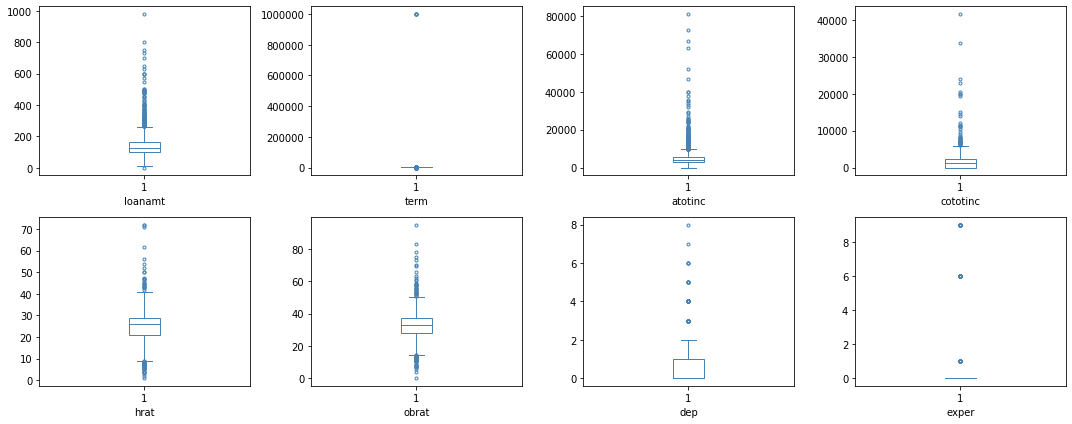

In [115]:
#Boxplot pour les variables quatitatives
c = 'steelblue'
blue_dict =  {'patch_artist': True,
             'boxprops': dict(color=c, facecolor='w'),
             'capprops': dict(color=c),
             'flierprops': dict(color=c, markeredgecolor=c,marker="."),
             'medianprops': dict(color=c),
             'whiskerprops': dict(color=c)}

plt.close()
plt.figure(1)
plt.figure(figsize=(15,6))
for i in np.arange(start=0,stop=data_quanti.shape[1]):
    plt.subplot(2, 4, i+1)
    plt.boxplot(data_quanti.iloc[:,i],**blue_dict)
    plt.xlabel(data_quanti.columns[i])
plt.tight_layout()
plt.show()

Les boites à moustache nous permettent de détecter des valeurs extremes ou abérrantes. On remarque notament pour la variable **term** des valeurs qui semblent abérantes. En effet, pour 3 individus le nombre de mois de demandé pour rembrouser le crédit immobilier et de 1 000 000. On peut supposer que des 0 sont en trop, ou qu'il s'agit de cas extreme. Nous préferons donc les exclures de la base de données.

count      1963.000000
mean       2377.836729
std       45090.981622
min           6.000000
25%         360.000000
50%         360.000000
75%         360.000000
max      999999.375000
Name: term, dtype: float64

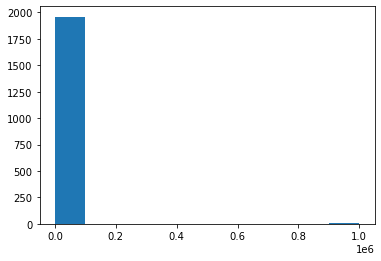

In [8]:
#Faisons une histogramme de la variable term pour mieux identifier cette valeur
plt.hist(data_quanti.iloc[:,1])
data_quanti.iloc[:,1].describe()

In [76]:
#Suppression d'outliers
data2=data1[(data1["term"]<500)] 
data2.shape

(1959, 20)

# Eatpe 2: Analyse Univariée

## 2.1. Analyse univariée des variables quantitatives

Dans le jeu de données « Loan_data.csv », il y a 8 variables quantitatives (loanmt, term, atotinc, cototinc, hart, obrat, dep et exper). Pour chacune de ces variables, nous présentons les paramètres de tendances centrales (Moyenne, Maximum, Minimum, quantiles (25%, 50% et 75%)) et l’écart-type comme indicateur de dispersion.

### 2.1.1. Parametres des tendances centrales et indicateur de dispersion.

In [10]:
# Tableau des indicateurs
col = [ 1, 2, 4, 5, 6, 7, 12, 13]
data2.iloc[: , col].describe()

,loanamt,term,atotinc,cototinc,hrat,obrat,dep,exper
count,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000
mean,143.493619,340.835120,5160.489535,1552.738397,24.850373,32.452318,0.771822,0.207759
std,80.920571,64.770711,5206.785465,2373.606577,7.085904,8.226071,1.105979,0.991394
min,2.000000,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,100.000000,360.000000,2875.000000,0.000000,21.000000,28.000000,0.000000,0.000000
50%,127.000000,360.000000,3794.000000,1152.000000,25.900000,33.000000,0.000000,0.000000
75%,165.000000,360.000000,5583.000000,2417.000000,29.000000,37.000000,1.000000,0.000000
max,980.000000,480.000000,81000.000000,41667.000000,72.000000,95.000000,8.000000,9.000000


D'après les résultats du tableau des indicateurs ci-dessus, nous remarquons que le montant du prêt immobilier est compris entre 2,000.00 et 980,000.00 dollars US. Le montant du prêt immobilier est en moyenne de 143,493.619 dollars US. La durée moyenne du prêt est de 341 mois environ et la durée minimale respectivement maximale du prêt immobilier est respectivement 6 et 480 mois. Le revenu moyen mensuel total des emprunteurs est de 5160.490 dollars US. Le ratio des frais de logement par rapport au revenu (pourcentage total sur revenu) est de 24.85 c'est-à-dire que le revenu total des emprunteurs est 24 fois plus élevé que leur frais de logement en moyenne et ce ratio est compris entre 1 et 72. En outre, Le ratio des autres dépenses par rapport au revenu est de 32.45 en moyenne alors nous pouvons dire que les frais de logement représentent une grande part du budget des dépenses des emprunteurs. En moyenne, les personnes demandant le prêt ont seulement une personne à leur charge et ont en moyenne moins d'une année expérience professionnel.

### 2.1.2. Représentation graphique des variables quantitatives

**Graphique : Distribution de la variable loanamt**

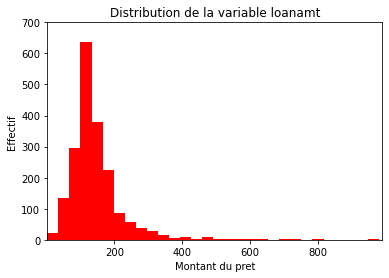

In [36]:
# Graphique: Distribution de la variable loanamt
plt.hist(data2.iloc[: , 1], bins=30, color='red')
plt.xlim(2, 990)
plt.ylim(0,700)
plt.xlabel('Montant du pret')
plt.ylabel('Effectif')
plt.title('Distribution de la variable loanamt')
plt.show()

Le graphique ci-dessus represente la distribution de la variable loanamt, en ordonnée, il y a la fréquence absolue des emprunteurs et en abscisse, il y a le montant le montant du prêt immobilier (en millier de dollar). Donc, le graphique montre que montant du pret le plus demandé par les empruteurs varie entre 50,000.00 et 200,000.00 dollars US.

**Graphique: Distribution de la variable term**

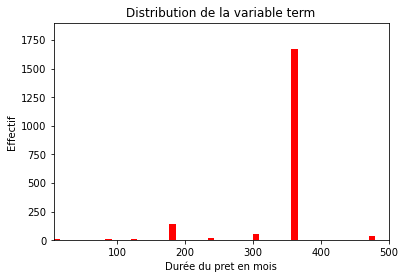

In [47]:
# Graphique: Distribution de la variable term
plt.hist(data2.iloc[: , 2], bins=50, color='red')
plt.xlim(6, 500)
plt.ylim(0,1900)
plt.xlabel('Durée du pret en mois')
plt.ylabel('Effectif')
plt.title('Distribution de la variable term')
plt.show()

**Graphique: Distribution de la variable atotinc** 

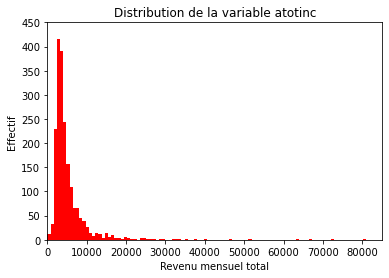

In [41]:
# Graphique: Distribution de la variable atotinc
plt.hist(data2.iloc[: , 4],bins=100, color='red')
plt.xlim(0, 85000)
plt.ylim(0,450)
plt.xlabel('Revenu mensuel total')
plt.ylabel('Effectif')
plt.title('Distribution de la variable atotinc')
plt.show()

**Graphique: Distribution de la variable cototinc**

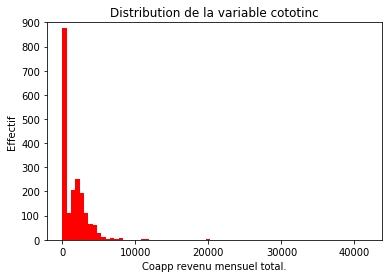

In [79]:
# Graphique: Distribution de la variable cototinc
plt.hist(data2.iloc[: , 5], bins=70, color='red')
plt.xlim(0, 50000)
plt.ylim(0,900)
plt.xlabel('Coapp revenu mensuel total.')
plt.ylabel('Effectif')
plt.title('Distribution de la variable cototinc')
plt.show()

**Graphique: Distribution de la variable hrat**

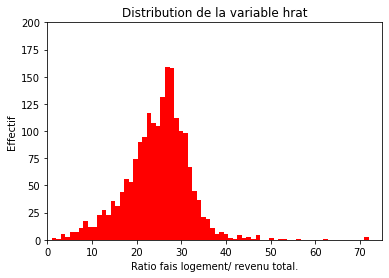

In [62]:
# Graphique: Distribution de la variable hrat
plt.hist(data2.iloc[: , 6], bins=70, color='red')
plt.xlim(0, 75)
plt.ylim(0,200)
plt.xlabel('Ratio fais logement/ revenu total.')
plt.ylabel('Effectif')
plt.title('Distribution de la variable hrat')
plt.show()

**Graphique: Disttribution de la variable obrat**

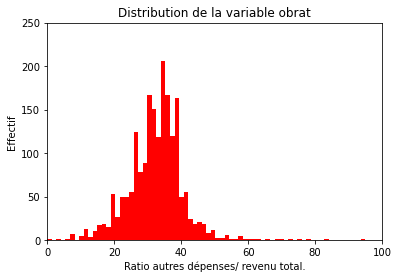

In [64]:
# Graphique: Distribution de la variable obrat
plt.hist(data2.iloc[: , 7], bins=70, color='red')
plt.xlim(0, 100)
plt.ylim(0,250)
plt.xlabel('Ratio autres dépenses/ revenu total.')
plt.ylabel('Effectif')
plt.title('Distribution de la variable obrat')
plt.show()

**Graphique:Distribution de la variable dep**

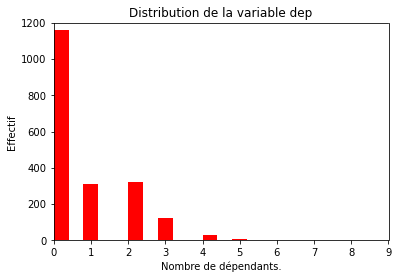

In [79]:
# Graphique: Distribution de la variable dep
plt.hist(data2.iloc[: , 12], bins=20, color='red')
plt.xlim(0, 9)
plt.ylim(0,1200)
plt.xlabel('Nombre de dépendants.')
plt.ylabel('Effectif')
plt.title('Distribution de la variable dep')
plt.show()


**Graphique: Distribution de la variable expr**

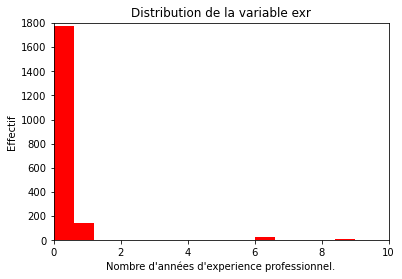

In [81]:
# Graphique: Distribution de la variable expr
plt.hist(data2.iloc[: , 13], bins=15, color='red')
plt.xlim(0, 10)
plt.ylim(0,1800)
plt.xlabel('Nombre d\'années d\'experience professionnel.')
plt.ylabel('Effectif')
plt.title('Distribution de la variable exr')
plt.show()

## 2.2.  Analyse Univarée des variables qualitatives

Dans la base de données "Loan_data.csv", nous avons 12 variables qualitatives que nous allons analyser ces variables en présentant un graphique pour visualiser leur distribution et en donant un tri a plat de chaque variable.

### 2.2.1. Tri à plat et graphique des variables qualitatives.

In [81]:
#---2.2. Analyse univariee des variables qualitatives----##

#Creation d'une novelle table contenant seulement les variables qualitatives
col1=[0,3,8,9,10,11,14,15,16,17,18,19]
data_quali = data2.iloc[:,col1]
data_quali.shape
data_quali.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1959 entries, 1 to 1988
Data columns (total 12 columns):
approve       1959 non-null int64
caution       1959 non-null int64
sex           1959 non-null object
university    1959 non-null int64
race          1959 non-null object
married       1959 non-null float64
self          1959 non-null int64
score         1959 non-null float64
delinq        1959 non-null int64
mortperf      1959 non-null int64
mortlat1      1959 non-null int64
mortlat2      1959 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 199.0+ KB


In [82]:
#Renommer les modalités des variables binaires
data_quali["Approve_rec"] = data_quali.iloc[:,0].replace({1: "Oui", 0: "Non"})
data_quali["caution_rec"] = data_quali.iloc[:,1].replace({1: "Une Miise en Garde", 0: "Pas de Mise en Garde"})
data_quali["uni_rec"] = data_quali.iloc[:,3].replace({1: "Oui", 0: "Non"})
data_quali["married_rec"] = data_quali.iloc[:,5].replace({1: "Oui", 0: "Non"})
data_quali["self_rec"] = data_quali.iloc[:,6].replace({1: "Oui", 0: "Non"})
data_quali["delinq_rec"] = data_quali.iloc[:,8].replace({1: "Oui", 0: "Non"})
data_quali["mortperf_rec"] = data_quali.iloc[:,9].replace({1: "Oui", 0: "Non"})
data_quali["mortlat1_rec"] = data_quali.iloc[:,10].replace({1: "Oui", 0: "Non"})
data_quali["mortlat2_rec"] = data_quali.iloc[:,12].replace({1: "Oui", 0: "Non"})

data_quali.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1959 entries, 1 to 1988
Data columns (total 21 columns):
approve         1959 non-null int64
caution         1959 non-null int64
sex             1959 non-null object
university      1959 non-null int64
race            1959 non-null object
married         1959 non-null float64
self            1959 non-null int64
score           1959 non-null float64
delinq          1959 non-null int64
mortperf        1959 non-null int64
mortlat1        1959 non-null int64
mortlat2        1959 non-null int64
Approve_rec     1959 non-null object
caution_rec     1959 non-null object
uni_rec         1959 non-null object
married_rec     1959 non-null object
self_rec        1959 non-null object
delinq_rec      1959 non-null object
mortperf_rec    1959 non-null object
mortlat1_rec    1959 non-null object
mortlat2_rec    1959 non-null object
dtypes: float64(2), int64(8), object(11)
memory usage: 336.7+ KB


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [83]:
# Tri à plat des variables
col3=[2,4,7,12,13,14,15,16,17,18,19,20]
for i in col3:
    tri_plat=data_quali.iloc[:,i].value_counts()
    print('Tri à plat de la variable',data_quali.columns[i],':','\n', tri_plat)
    print('\n')

Tri à plat de la variable sex : 
 Male      1592
Female     367
Name: sex, dtype: int64


Tri à plat de la variable race : 
 White     1658
Black      193
Hispan     108
Name: race, dtype: int64


Tri à plat de la variable score : 
 1.0    970
2.0    610
0.0    174
4.0    101
3.0     91
6.0      7
5.0      4
9.0      1
8.0      1
Name: score, dtype: int64


Tri à plat de la variable Approve_rec : 
 Oui    1718
Non     241
Name: Approve_rec, dtype: int64


Tri à plat de la variable caution_rec : 
 Pas de Mise en Garde    1905
Une Miise en Garde        54
Name: caution_rec, dtype: int64


Tri à plat de la variable uni_rec : 
 Oui    1508
Non     451
Name: uni_rec, dtype: int64


Tri à plat de la variable married_rec : 
 Oui    1290
Non     669
Name: married_rec, dtype: int64


Tri à plat de la variable self_rec : 
 Non    1706
Oui     253
Name: self_rec, dtype: int64


Tri à plat de la variable delinq_rec : 
 Oui    1638
Non     321
Name: delinq_rec, dtype: int64


Tri à plat de la varia

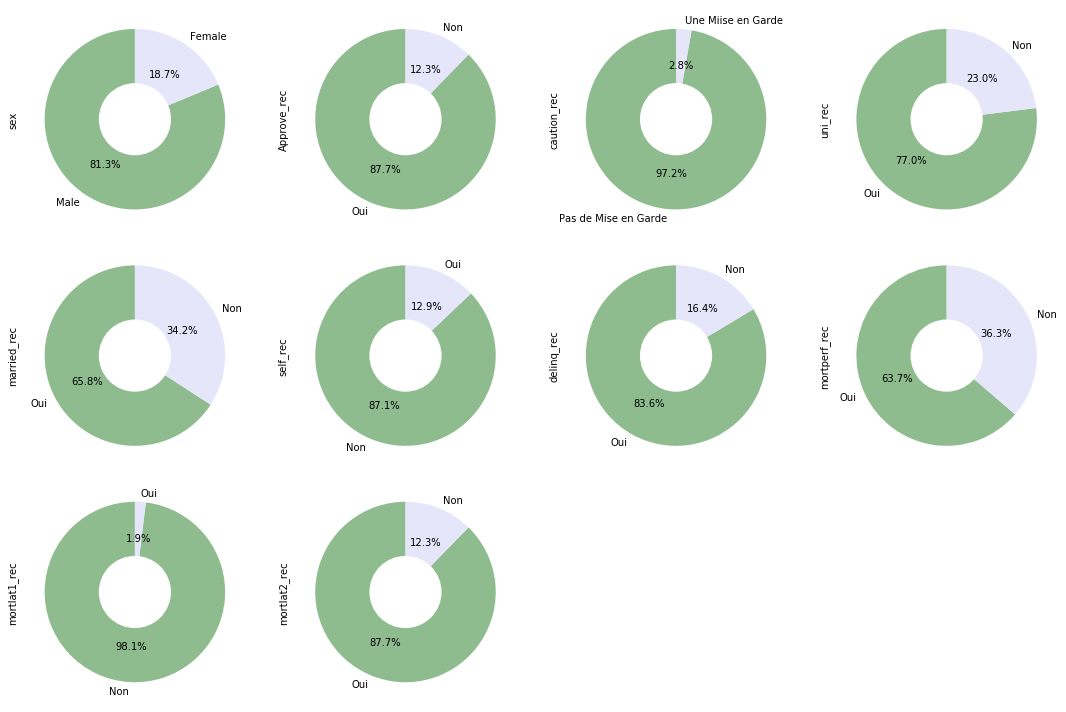

In [110]:
#Pie des varibales qualitatives binaires
col3=[2,12,13,14,15,16,17,18,19,20]

j=1
plt.figure(figsize=(15,10))
for i in col3:
    plt.subplot(3, 4, j)
    j=j+1
    data_quali.iloc[:,i].value_counts().plot.pie(subplots=True , autopct='%1.1f%%',startangle=90, colors = [ 'darkseagreen','lavender'])
    centre_circle = plt.Circle((0,0),0.4,color='black', fc='white',linewidth=0)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle) 
plt.tight_layout() 
plt.show()

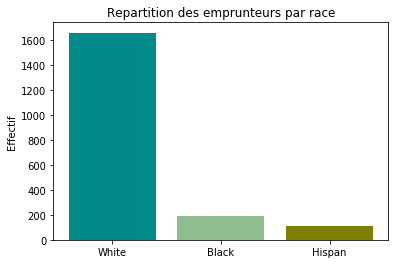

In [112]:
# Bar plot de la variable race 
plt.bar(['White', 'Black', 'Hispan'], [1658, 193, 108], color=['darkcyan','darkseagreen', 'olive'], width=0.8)
plt.ylabel('Effectif')
plt.title('Repartition des emprunteurs par race')
plt.show()

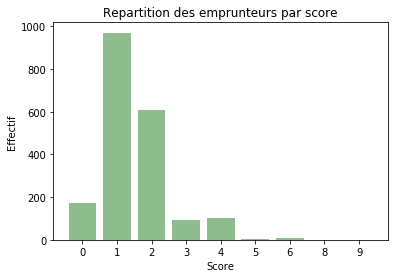

In [113]:
# Bar plot de la variable score
plt.bar(['0', '1', '2', '3', '4', '5', '6', '8', '9'], [174,970,610,91,101,4,7,1,1], color=['darkseagreen'])
plt.ylabel('Effectif')
plt.xlabel('Score')
plt.title('Repartition des emprunteurs par score')
plt.show()